## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [2]:
import os
import tensorflow.keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [3]:
train, test = tensorflow.keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = tensorflow.keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [13]:
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization


def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-8, drp_ratio=0.2):
    input_layer = tensorflow.keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = tensorflow.keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
        else:
            x = tensorflow.keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
    
    out = tensorflow.keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = tensorflow.keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [11]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
Dropout_EXP = 0.25
L2_EXP = 1e-8

In [14]:
result = {}
model = build_mlp(input_shape=x_train.shape[1:], drp_ratio=Dropout_EXP, l2_ratio=L2_EXP)
model.summary()
optimizer = tensorflow.keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024  

Epoch 43/50
50000/50000 [==============================] - 7s 142us/sample - loss: 1.3486 - accuracy: 0.5145 - val_loss: 1.3727 - val_accuracy: 0.5103
Epoch 44/50
50000/50000 [==============================] - 7s 142us/sample - loss: 1.3411 - accuracy: 0.5177 - val_loss: 1.3809 - val_accuracy: 0.5090
Epoch 45/50
50000/50000 [==============================] - 7s 141us/sample - loss: 1.3409 - accuracy: 0.5184 - val_loss: 1.3706 - val_accuracy: 0.5122
Epoch 46/50
50000/50000 [==============================] - 7s 141us/sample - loss: 1.3364 - accuracy: 0.5208 - val_loss: 1.3678 - val_accuracy: 0.5088
Epoch 47/50
50000/50000 [==============================] - 7s 141us/sample - loss: 1.3431 - accuracy: 0.5160 - val_loss: 1.3552 - val_accuracy: 0.5185
Epoch 48/50
50000/50000 [==============================] - 7s 141us/sample - loss: 1.3315 - accuracy: 0.5231 - val_loss: 1.3872 - val_accuracy: 0.5071
Epoch 49/50
50000/50000 [==============================] - 7s 141us/sample - loss: 1.3260 - ac

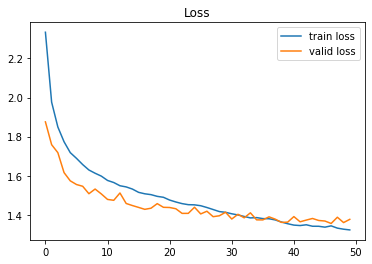

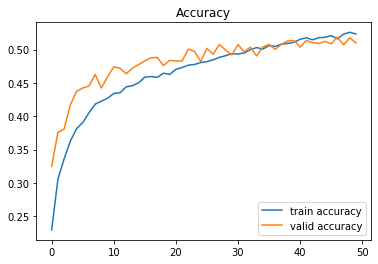

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()